# Pairwise minhash comp with Neural network (torch)
Run neural networks from keras on minhash presence inputs; output from presence_matrix()

## Minhash presence matrix 

In [7]:
# Setting up and obtaining unique minhashes

import sourmash, os, sys
from tqdm import tqdm
import pandas as pd
import numpy as np
from io_operations import presence_matrix
from time import time
from datetime import datetime

time_start = time()

raw_data_path = "../raw_data/"
data_prod_path = "../data_prod/"
#for n in [50, 500, 5000, 10000, 50000]:
n = 500
k = 18

binary_matrix, entity_to_index, minhash_to_index, phage_minhash_data, bact_minhash_data = presence_matrix(n=n, k=k, reversecomp_data=True, TS=True)

Loading phage minhash sketches from: ../data_prod/SM_sketches/PhageMinhash_n500_k18_rev/
Loading bacteria minhash sketches from: ../data_prod/SM_sketches/BactMinhash_n500_k18_rev/

Unique minhashes extracted with len: 28895

Binary presence matrix created with shape: (133, 28895)
Sample rows (entities): ['Abuela', 'Amona', 'Crus', 'Echoes', 'FO3A_23_KMC_reoriented']
Sample columns (minhashes): [np.int64(90281211652), np.int64(278436322795), np.int64(405012416096), np.int64(470210724260), np.int64(482172228249)]


#### hostrange data for lookup 
(y value : target for RandomForest network)

In [8]:
from io_operations import call_hostrange_df
bact_lookup, host_range_df = call_hostrange_df(raw_data_path + "phagehost_KU/Hostrange_data_all_crisp_iso.xlsx")
print(bact_lookup)
display(host_range_df)

{'J14_21_reoriented': 'Acinetobacter calcoaceticus', 'J53_21_reoriented': 'Acinetobacter calcoaceticus', 'J105_22_reoriented': 'Chishuiella', 'J46_21_reoriented': 'Chryseobacterium', 'J50_21_reoriented': 'Chryseobacterium', 'J2264_1_22_KMC_reoriented': 'Chryseobacterium', 'J2264_3_22_KMC_reoriented': 'Chryseobacterium', 'J63_22_reoriented': 'Chryseobacterium', 'J64_22_reoriented': 'Chryseobacterium', 'J1_21_reoriented': 'Lelliottia', 'J91_22_reoriented': 'Lelliottia', 'J51_21_reoriented': 'Morganella morganii', 'J57_21_reoriented': 'Morganella morganii', 'J10_21_reoriented': 'Pectobacterium atrosepticum', 'J11_21_reoriented': 'Pectobacterium atrosepticum', 'J126_23_reoriented': 'Pectobacterium atrosepticum', 'J12_21_reoriented': 'Pectobacterium atrosepticum', 'J16_21_reoriented': 'Pectobacterium atrosepticum', 'J22_21_reoriented': 'Pectobacterium atrosepticum', 'J28_21_reoriented': 'Pectobacterium atrosepticum', 'J33_21_reoriented': 'Pectobacterium atrosepticum', 'J38_21_reoriented': '

,phage,Ymer,Taid,Poppous,Koroua,Abuela,Amona,Sabo,Mimer,Crus,...,Vims,Echoes,Galvinrad,Uther,Rip,Rup,Slaad,Pantea,Rap,Zann
0,J14_21_reoriented,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,J53_21_reoriented,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,J105_22_reoriented,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,J46_21_reoriented,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,J50_21_reoriented,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,J109_23_reoriented,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106,J101_22_reoriented,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107,J15_21_reoriented,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,800000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,J4_21_reoriented,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Isolation host,Isolation host,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
from manipulations import hostrange_df_to_dict, binarize_host_range

# Convert the host range data into a dictionary
host_range_data = hostrange_df_to_dict(host_range_df)
host_range_data = binarize_host_range(host_range_data, continous=False) #for classification model

#host_range_data["J10_21_reoriented"]

### Prepare outdir for plots

In [10]:
run = 1
path_to_fig = "../fig/"
outdir = path_to_fig+f'torch_mlp_n{n}_k{k}_run{run}/'

while os.path.exists(outdir):
    run += 1
    outdir = path_to_fig+f'torch_mlp_n{n}_k{k}_run{run}/'

os.makedirs(outdir, exist_ok=True)

# Open logfile for run
logfile = open(outdir+f'torchMLP_log_run{run}.txt', 'w')
logfile.write(f'Torch MLP log for n={n}, k={k}\n')
logfile.write('-----------------------------------\n')

36

### Setting up for torch

In [11]:
X = []
y = []
rows_metadata = [] # To keep track of which entities form the row

phage_names = phage_minhash_data.keys()
bacteria_names = bact_minhash_data.keys()

# Iterate through all valid phage-bacteria pairs (the required pairwise iteration)
for bact_name in tqdm(bacteria_names, desc="Bacteria names iterated"):
    for phage_name in phage_names:
        # Get the interaction score (target variable y)
        try:
            interaction_score = host_range_data[bact_name][phage_name]
        except KeyError:
            continue

        # Get the feature vectors (rows from the incidence matrix)
        bact_index = entity_to_index[bact_name]
        phage_index = entity_to_index[phage_name]

        bact_features = binary_matrix[bact_index, :]
        phage_features = binary_matrix[phage_index, :]

        # Concatenate: [Bacterium Features | Phage Features]
        combined_features = np.concatenate((bact_features, phage_features))

        X.append(combined_features)
        y.append(interaction_score)
        #print(X)
        #print(y)
        rows_metadata.append((bact_name, phage_name))

X = np.array(X)
y = np.array(y)

print("Unique values found in train y:", set(y))
print(f'{datetime.now().strftime("[%Y-%m-%d %H:%M:%S] ")} Unique values found in train y:', set(y), file=logfile)
print(f"Percent zeros in train y: {round(([sum(val == 0 for val in y)][0]/len(y))*100,2)}%")
print(f'{datetime.now().strftime("[%Y-%m-%d %H:%M:%S] ")} Percent zeros in train y: {round(([sum(val == 0 for val in y)][0]/len(y))*100,2)}%', file=logfile)

# Check if we have enough data to proceed
if X.shape[0] < 2:
    print(f"Error: Not enough data points ({X.shape[0]} found) for train-test split.")
    print(f'{datetime.now().strftime("[%Y-%m-%d %H:%M:%S] ")} Error: Not enough data points ({X.shape[0]} found) for train-test split.', file=logfile)
    sys.exit(1)

Bacteria names iterated: 100%|██████████| 110/110 [00:00<00:00, 561.93it/s]


Unique values found in train y: {np.int64(0), np.int64(1)}
Percent zeros in train y: 92.33%


### Running torch nn

In [13]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim

# Hyperparameters
n_epochs = 50
learning_rate = 1e-3
batch_size = 64 # adjust based on dataset size and memory
test_split_ratio = 0.2
val_split_ratio = 0.2

# Prepare train / val / test split (use stratify if possible)
strat = y if np.unique(y).size > 1 else None
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=test_split_ratio, random_state=42, stratify=strat
)
# now split training part into train + val (use stratify on the training labels if possible)
strat_train = y_train_full if np.unique(y_train_full).size > 1 else None
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=val_split_ratio / (1 - test_split_ratio), random_state=42, stratify=strat_train
)
print(f"Data split into train/val/test with test size {test_split_ratio*100}% and val size {val_split_ratio*100}%")
print(f"Train size: {X_train.shape[0]} samples, Val size: {X_val.shape[0]} samples, Test size: {X_test.shape[0]} samples")

# Scale features (fit only on training set)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert to torch tensors
X_train_t = torch.from_numpy(X_train).float()
X_val_t = torch.from_numpy(X_val).float()
X_test_t = torch.from_numpy(X_test).float()
y_train_t = torch.from_numpy(y_train.reshape(-1, 1)).float()
y_val_t = torch.from_numpy(y_val.reshape(-1, 1)).float()
y_test_t = torch.from_numpy(y_test.reshape(-1, 1)).float()

# Datasets / loaders
train_ds = TensorDataset(X_train_t, y_train_t)
val_ds = TensorDataset(X_val_t, y_val_t)
test_ds = TensorDataset(X_test_t, y_test_t)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# epoch stats
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Simple MLP for binary classification
class MLP(nn.Module):
    def __init__(self, input_dim, hidden1=256, hidden2=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden2, 1)  # logits for BCEWithLogitsLoss
        )
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f'{datetime.now().strftime("[%Y-%m-%d %H:%M:%S] ")} Using device: {device}', file=logfile)

model = MLP(input_dim=X_train.shape[1]).to(device)
criterion = nn.BCEWithLogitsLoss() #Loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate) #Optimizes weights and biases

# Training loop
print(f'\n{datetime.now().strftime("[%Y-%m-%d %H:%M:%S] ")} Starting training with epochs: {n_epochs}...\n', file=logfile)
for epoch in range(1, n_epochs + 1):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Evaluate on validation set each epoch
    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        val_running_loss = 0.0
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            val_running_loss += loss.item() * xb.size(0)
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()
            correct += (preds == yb).sum().item()
            total += yb.numel()
        val_loss = val_running_loss / len(val_loader.dataset) if len(val_loader.dataset) > 0 else float('nan')
        val_acc = correct / total if total > 0 else float('nan')
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

    print(f"Epoch {epoch:02d} - train_loss: {epoch_loss:.4f} - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}")
    print(f'{datetime.now().strftime("[%Y-%m-%d %H:%M:%S] ")} Epoch {epoch:02d} - train_loss: {epoch_loss:.4f} - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}', file=logfile)

# Final evaluation on test set: loss + accuracy
model.eval()
with torch.no_grad():
    test_logits = model(X_test_t.to(device))
    test_loss = criterion(test_logits, y_test_t.to(device)).item()
    test_probs = torch.sigmoid(test_logits)
    test_preds = (test_probs >= 0.5).float()
    test_acc = (test_preds.cpu() == y_test_t).float().mean().item()

print(f"\nFinal test loss: {test_loss:.4f}  test accuracy: {test_acc:.4f}")
print(f'\n{datetime.now().strftime("[%Y-%m-%d %H:%M:%S] ")} Final test loss: {test_loss:.4f}  test accuracy: {test_acc:.4f}', file=logfile)

Data split into train/val/test with test size 20.0% and val size 20.0%
Train size: 1518 samples, Val size: 506 samples, Test size: 506 samples
Using device: cpu
Epoch 01 - train_loss: 0.3573 - val_loss: 0.1791 - val_acc: 0.9328
Epoch 02 - train_loss: 0.1327 - val_loss: 0.1809 - val_acc: 0.9447
Epoch 03 - train_loss: 0.1231 - val_loss: 0.1827 - val_acc: 0.9466
Epoch 04 - train_loss: 0.1008 - val_loss: 0.1599 - val_acc: 0.9526
Epoch 05 - train_loss: 0.0946 - val_loss: 0.1504 - val_acc: 0.9506
Epoch 06 - train_loss: 0.0977 - val_loss: 0.1616 - val_acc: 0.9466
Epoch 07 - train_loss: 0.1349 - val_loss: 0.3020 - val_acc: 0.9506
Epoch 08 - train_loss: 0.1163 - val_loss: 0.2777 - val_acc: 0.9545
Epoch 09 - train_loss: 0.0940 - val_loss: 0.1490 - val_acc: 0.9506
Epoch 10 - train_loss: 0.0755 - val_loss: 0.1254 - val_acc: 0.9605
Epoch 11 - train_loss: 0.0743 - val_loss: 0.1421 - val_acc: 0.9486
Epoch 12 - train_loss: 0.0760 - val_loss: 0.1352 - val_acc: 0.9545
Epoch 13 - train_loss: 0.0665 - val

### Accuracy and training loss

/var/folders/sd/ygh_pqf56ygdrztjkzy96_s00000gn/T/ipykernel_10709/554931681.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


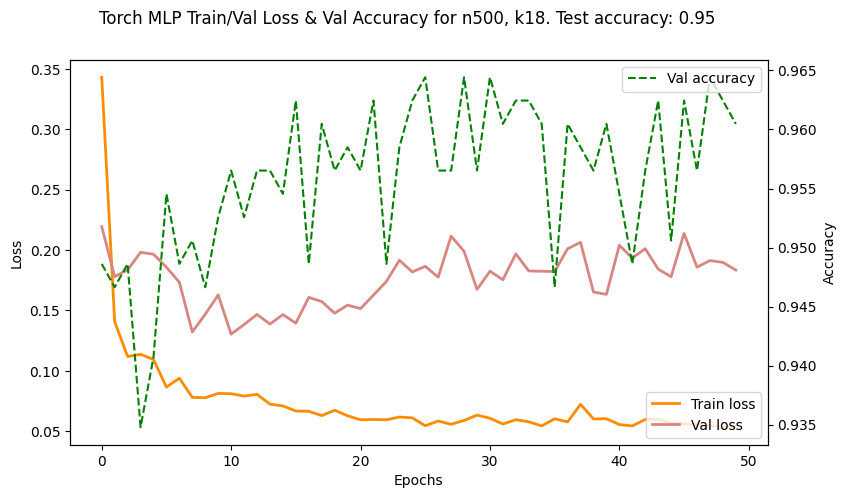

In [107]:
import matplotlib.pyplot as plt
# Plotting the losses 
fig,ax = plt.subplots(1,1, figsize=(9,5))

ax.plot(range(n_epochs), train_losses, label='Train loss', color='#FF8C00', linewidth=2)
ax.plot(range(n_epochs), val_losses, label='Val loss', color="#D88682", linewidth=2)
ax.legend(loc='lower right')
ax.set_ylabel('Loss')

ax2 = ax.twinx()
ax2.plot(range(n_epochs), val_accuracies, label='Val accuracy', c='g', linestyle='--')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='upper right')

ax.set_xlabel('Epochs')
fig.suptitle(f"Torch MLP Train/Val Loss & Val Accuracy for n{n}, k{k}. Test accuracy: {test_acc:.2f}")
fig.show()

outname = 'torchMLP_acc_loss.png'    
plt.savefig(outdir+outname)

print(f'{datetime.now().strftime("[%Y-%m-%d %H:%M:%S] ")} Accuracy and train figure saved as: {outdir+outname}', file=logfile)


### ROC & Confusion matrix

In [108]:
model.eval() # Set the model to evaluation mode
all_logits = []
all_labels = []

with torch.no_grad(): # Disable gradient calculations for inference
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # 1. Forward pass to get logits
        logits = model(inputs)

        all_logits.append(logits.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all results
logits = np.concatenate(all_logits)
true_labels = np.concatenate(all_labels)

In [109]:
from scipy.special import expit # Equivalent to the Sigmoid function

# Convert logits to probabilities (since you used BCEWithLogitsLoss)
# Logits are the input to the sigmoid function to get probabilities.
probabilities = expit(logits).flatten()

# Convert probabilities to predicted classes (0 or 1)
# Use a threshold of 0.5 (standard for binary classification)
predicted_classes = (probabilities >= 0.5).astype(int)

#### Confusion matrix

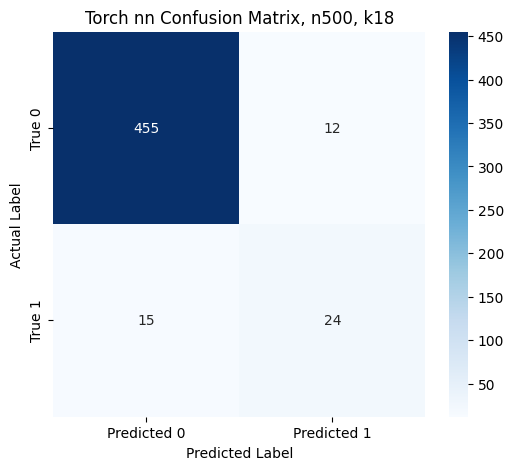

In [110]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Plotting the confusion matrix (optional but recommended)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['True 0', 'True 1'])
plt.title(f'Torch nn Confusion Matrix, n{n}, k{k}')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

outname = 'torchMLP_confusion_matrix.png'
plt.savefig(outdir+outname)
plt.show()

print(f'{datetime.now().strftime("[%Y-%m-%d %H:%M:%S] ")} Confusion matrix figure saved as: {outdir+outname}', file=logfile)
# Interpretation:
# cm[0, 0]: True Negatives (TN)
# cm[0, 1]: False Positives (FP)
# cm[1, 0]: False Negatives (FN)
# cm[1, 1]: True Positives (TP)

#### ROC curve

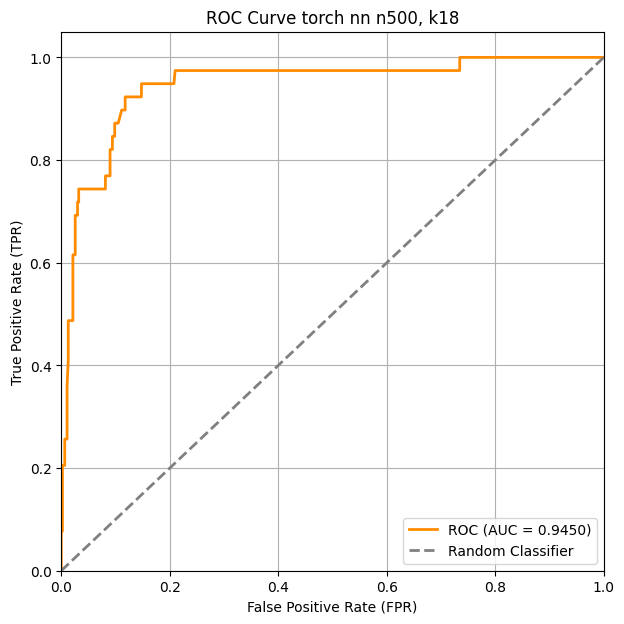

In [111]:
from sklearn.metrics import roc_curve, roc_auc_score

# 1. Calculate AUC
# Probabilities are needed here, not the final class prediction
roc_auc = roc_auc_score(true_labels, probabilities)

# 2. Calculate the ROC curve points
# Returns FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(true_labels, probabilities)

# 3. Plot the ROC Curve

plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--',
         label='Random Classifier') # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title(f'ROC Curve torch nn n{n}, k{k}')
plt.legend(loc="lower right")
plt.grid(True)

outname = 'torchMLP_ROC.png'
plt.savefig(outdir+outname)
plt.show()

print(f'{datetime.now().strftime("[%Y-%m-%d %H:%M:%S] ")} ROC curve figure saved as: {outdir+outname}', file=logfile)

#### F1

Baseline (threshold=0.5) -> Precision: 0.7368, Recall: 0.7179, F1: 0.7273
Best threshold by F1 -> threshold=0.500, Precision=0.7368, Recall=0.7179, F1=0.7273

Classification report at best threshold:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       467
           1       0.74      0.72      0.73        39

    accuracy                           0.96       506
   macro avg       0.86      0.85      0.85       506
weighted avg       0.96      0.96      0.96       506

Average precision (AP): 0.7148
Confusion matrix (rows=true, cols=pred):
 [[457  10]
 [ 11  28]]


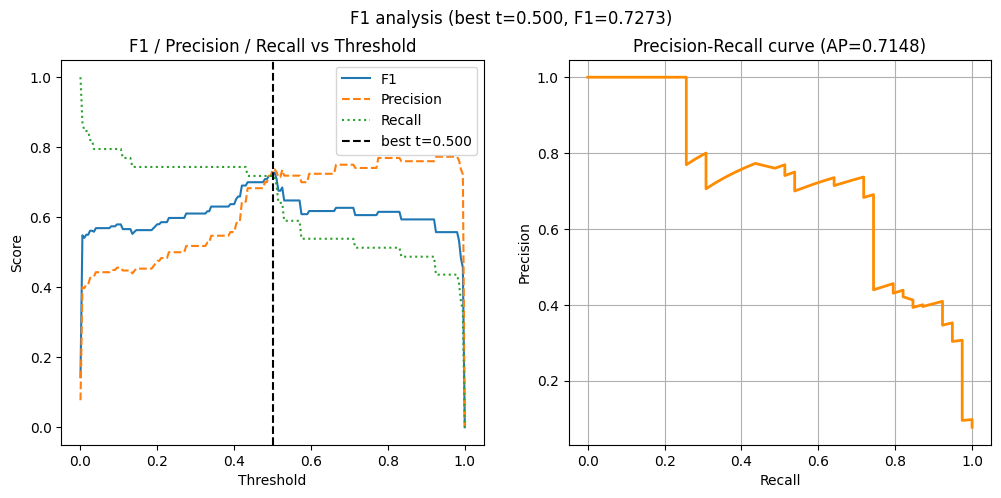

In [14]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, precision_recall_curve, average_precision_score, confusion_matrix

# F1 analysis (uses existing variables: test_probs (torch.Tensor), y_test (np.array), outdir, logfile)
import matplotlib.pyplot as plt

# Prepare arrays
probs = test_probs.flatten().cpu().numpy() if hasattr(test_probs, "cpu") else test_probs.flatten()
y_true = y_test.flatten()  # already numpy

# Baseline at 0.5
pred_05 = (probs >= 0.5).astype(int)
prec_05 = precision_score(y_true, pred_05, zero_division=0)
rec_05 = recall_score(y_true, pred_05, zero_division=0)
f1_05 = f1_score(y_true, pred_05, zero_division=0)

print(f"Baseline (threshold=0.5) -> Precision: {prec_05:.4f}, Recall: {rec_05:.4f}, F1: {f1_05:.4f}")
print(f'{datetime.now().strftime("[%Y-%m-%d %H:%M:%S] ")} Baseline (threshold=0.5) -> Precision: {prec_05:.4f}, Recall: {rec_05:.4f}, F1: {f1_05:.4f}', file=logfile)

# Sweep thresholds to find best F1
thresholds = np.linspace(0.0, 1.0, 201)
f1s = []
prcs = []
recs = []
for t in thresholds:
    preds = (probs >= t).astype(int)
    f1s.append(f1_score(y_true, preds, zero_division=0))
    prcs.append(precision_score(y_true, preds, zero_division=0))
    recs.append(recall_score(y_true, preds, zero_division=0))
f1s = np.array(f1s)
prcs = np.array(prcs)
recs = np.array(recs)

best_idx = np.argmax(f1s)
best_t = thresholds[best_idx]
best_f1 = f1s[best_idx]
best_prec = prcs[best_idx]
best_rec = recs[best_idx]

print(f"Best threshold by F1 -> threshold={best_t:.3f}, Precision={best_prec:.4f}, Recall={best_rec:.4f}, F1={best_f1:.4f}")
print(f'{datetime.now().strftime("[%Y-%m-%d %H:%M:%S] ")} Best threshold by F1 -> threshold={best_t:.3f}, Precision={best_prec:.4f}, Recall={best_rec:.4f}, F1={best_f1:.4f}', file=logfile)

# Classification report at best threshold
best_preds = (probs >= best_t).astype(int)
report = classification_report(y_true, best_preds, zero_division=0)
print("\nClassification report at best threshold:\n", report)
print(f'{datetime.now().strftime("[%Y-%m-%d %H:%M:%S] ")} Classification report at best threshold:\n{report}', file=logfile)

# Average precision (area under PR curve)
precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, probs)
avg_prec = average_precision_score(y_true, probs)
print(f"Average precision (AP): {avg_prec:.4f}")
print(f'{datetime.now().strftime("[%Y-%m-%d %H:%M:%S] ")} Average precision (AP): {avg_prec:.4f}', file=logfile)

# Confusion matrix at best threshold
cm = confusion_matrix(y_true, best_preds)
print("Confusion matrix (rows=true, cols=pred):\n", cm)
print(f'{datetime.now().strftime("[%Y-%m-%d %H:%M:%S] ")} Confusion matrix:\n{cm}', file=logfile)

# Plots: F1 vs threshold and Precision-Recall curve
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(thresholds, f1s, label='F1', color='C0')
axes[0].plot(thresholds, prcs, label='Precision', color='C1', linestyle='--')
axes[0].plot(thresholds, recs, label='Recall', color='C2', linestyle=':')
axes[0].axvline(best_t, color='k', linestyle='--', label=f'best t={best_t:.3f}')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Score')
axes[0].set_title('F1 / Precision / Recall vs Threshold')
axes[0].legend()

axes[1].plot(recall_curve, precision_curve, color='darkorange', lw=2)
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title(f'Precision-Recall curve (AP={avg_prec:.4f})')
axes[1].grid(True)

plt.suptitle(f'F1 analysis (best t={best_t:.3f}, F1={best_f1:.4f})')
outname = 'torchMLP_f1_analysis.png'
plt.savefig(outdir + outname, bbox_inches='tight')
plt.show()

print(f'{datetime.now().strftime("[%Y-%m-%d %H:%M:%S] ")} F1 analysis figure saved as: {outdir+outname}', file=logfile)

### End of run

In [112]:
print(f'\n{datetime.now().strftime("[%Y-%m-%d %H:%M:%S] ")} End of run.\nExecuted in {time()-time_start}s', file=logfile)
logfile.close()